# Frame Overlap Tutorial

This tutorial demonstrates how to use the `frame_overlap` package to analyze neutron Time-of-Flight (ToF) data, apply Wiener deconvolution, optimize parameters, and visualize results using pandas DataFrames.

In [1]:
import pandas as pd
from frame_overlap import (
    read_tof_data,
    generate_kernel,
    apply_filter,
    chi2_analysis,
    plot_analysis,
    optimize_parameters
)

## Step 1: Load ToF Data
Load the neutron ToF data from a CSV file into a pandas DataFrame. The file should contain columns 'stack', 'counts', and 'err'.

In [2]:
# Load data
signal_df = read_tof_data('iron_powder.csv', threshold=30)

# Inspect the first few rows
signal_df.head()

,time,counts,errors,stack
0,0,2534879.0,1592.130,1
1,10,606366.0,778.695,2
2,20,414140.0,643.537,3
3,30,288094.0,536.744,4
4,40,237405.0,487.242,5


## Step 2: Generate Kernel
Generate a kernel with specified parameters for convolution.

In [3]:
# Generate kernel
kernel_df = generate_kernel(n_pulses=1, pulse_duration=200, window_size=5000, bin_width=10)

# Inspect kernel
kernel_df.head()

,kernel_time,kernel_value
0,0,0.152546
1,10,0.130265
2,20,0.111238
3,30,0.094991
4,40,0.081116


## Step 3: Apply Wiener Deconvolution
Apply the Wiener filter to the signal to account for frame overlap.

In [4]:
# Apply Wiener filter
observed_df, reconstructed_df = apply_filter(
    signal_df,
    kernel_df,
    filter_type='wiener',
    stats_fraction=0.2,
    noise_power=0.05
)

# Inspect results
print("Observed DataFrame:")
print(observed_df)
print("\nReconstructed DataFrame:")
print(reconstructed_df)

Observed DataFrame:
      counts
0      40511
1      39990
2      40054
3      40080
4      39918
...      ...
2361       1
2362       1
2363       1
2364       1
2365       1

[2366 rows x 1 columns]

Reconstructed DataFrame:
      reconstructed
0     100939.052476
1      66549.331156
2      50902.643553
3      43230.391136
4      39223.318469
...             ...
2361    2441.964749
2362    5237.991662
2363   10954.338259
2364   23017.983338
2365   48208.957682

[2366 rows x 1 columns]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<Axes: >

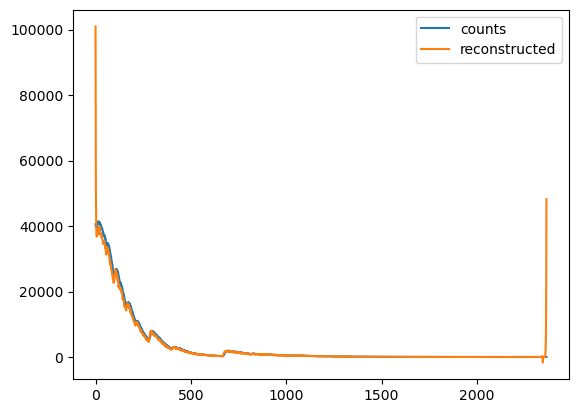

In [5]:
%pylab inline
observed_df.plot()
reconstructed_df.plot(ax=gca())

## Step 4: Calculate Chi-Squared
Calculate chi-squared statistics to evaluate the fit.

In [8]:
# Scale original signal
scaled_df = pd.DataFrame({'counts': signal_df['counts'] * 0.2})

# Calculate chi-squared
chi2, chi2_per_dof = chi2_analysis(
    scaled_df,
    reconstructed_df,
    pd.DataFrame({'errors': signal_df['errors']})
)
print(f"Chi-squared: {chi2:.2f}")
print(f"Reduced Chi-squared: {chi2_per_dof:.2f}")

Chi-squared: 73114378.53
Reduced Chi-squared: 30902.10


## Step 5: Visualize Results
Plot the original signal, scaled signal, kernel, observed signal, reconstructed signal, and residuals.

In [7]:
signal_df.shape

(2366, 4)

In [8]:
kernel_df.shape

(500, 2)

In [9]:
# Calculate residuals
residuals_df = pd.DataFrame({'residuals': scaled_df['counts'] - reconstructed_df['reconstructed']})

# Plot results
plot_analysis(
    signal_df[['time']],
    signal_df,
    scaled_df,
    kernel_df,
    observed_df,
    reconstructed_df,
    residuals_df,
    chi2_per_dof
)

ValueError: All signal-related DataFrames must have the same length

<Axes: >

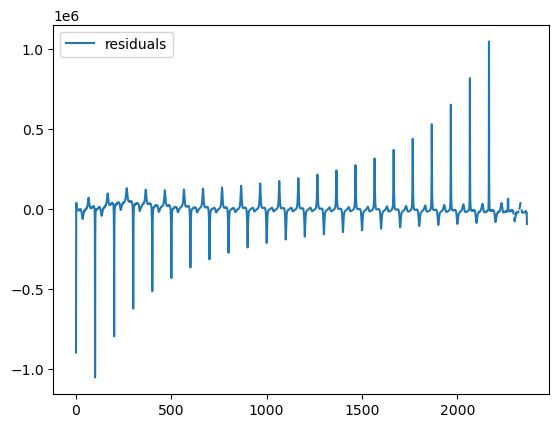

In [12]:
residuals_df.plot()

## Step 6: Optimize Parameters
Optimize the deconvolution parameters using lmfit.

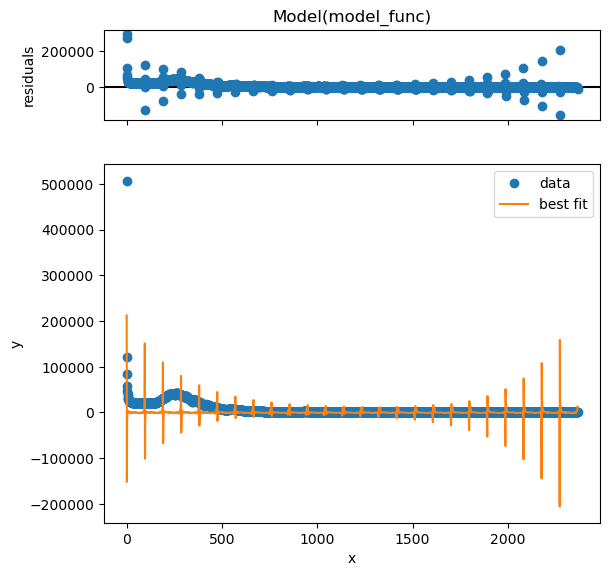

In [10]:
# Optimize parameters
t_signal_df = signal_df[['time']]
result = optimize_parameters(
    t_signal_df,
    signal_df.copy(),  # Create a copy to ensure DataFrame integrity
    initial_params={'n_pulses': 5, 'noise_power': 0.05, 'pulse_duration': 200}
)

# Print optimized parameters
print(result)

# Plot fit results
result.plot();